In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor


In [2]:
sales_data = pd.read_csv("../data/preprocessed/sales_and_purchase_prices.csv")
sales_data

,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName,Amount,PurchasePrice
0,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750.0,1,16.49,16.49,2016-01-01,750,1,0.79,12546,JIM BEAM BRANDS COMPANY,17.28,10.65
1,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750.0,2,32.98,16.49,2016-01-02,750,1,1.57,12546,JIM BEAM BRANDS COMPANY,34.55,10.65
2,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750.0,1,16.49,16.49,2016-01-03,750,1,0.79,12546,JIM BEAM BRANDS COMPANY,17.28,10.65
3,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750.0,1,14.49,14.49,2016-01-08,750,1,0.79,12546,JIM BEAM BRANDS COMPANY,15.28,10.65
4,1_HARDERSFIELD_1005,1,1005,Maker's Mark Combo Pack,750.0,2,69.98,34.99,2016-01-09,375,1,0.79,12546,JIM BEAM BRANDS COMPANY,70.77,27.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,19_WINTERVALE_39384,19,39384,F Coppola Diamond Pnt Nr,750.0,4,51.80,12.95,2016-02-12,750,2,0.45,2000,SOUTHERN WINE & SPIRITS NE,52.25,8.96
1048571,19_WINTERVALE_39384,19,39384,F Coppola Diamond Pnt Nr,750.0,8,103.60,12.95,2016-02-13,750,2,0.90,2000,SOUTHERN WINE & SPIRITS NE,104.50,8.96
1048572,19_WINTERVALE_39384,19,39384,F Coppola Diamond Pnt Nr,750.0,1,12.95,12.95,2016-02-19,750,2,0.11,2000,SOUTHERN WINE & SPIRITS NE,13.06,8.96
1048573,19_WINTERVALE_39384,19,39384,F Coppola Diamond Pnt Nr,750.0,3,38.85,12.95,2016-02-22,750,2,0.34,2000,SOUTHERN WINE & SPIRITS NE,39.19,8.96


In [3]:
sales_data.columns

Index(['InventoryId', 'Store', 'Brand', 'Description', 'Size', 'SalesQuantity',
       'SalesDollars', 'SalesPrice', 'SalesDate', 'Volume', 'Classification',
       'ExciseTax', 'VendorNo', 'VendorName', 'Amount', 'PurchasePrice'],
      dtype='object')

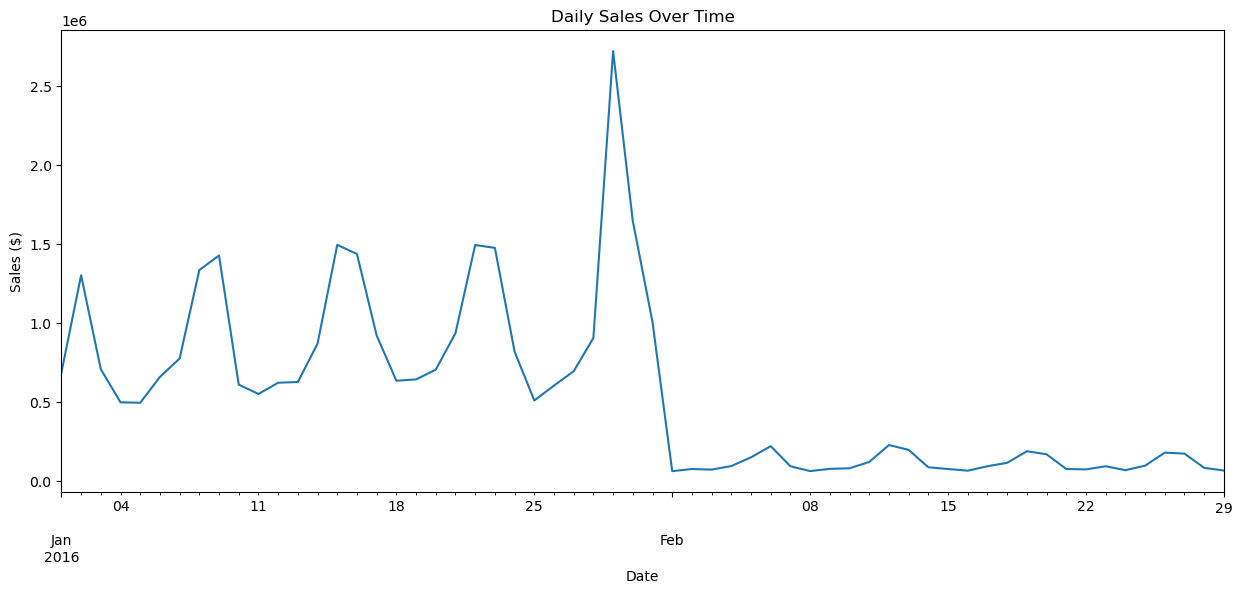

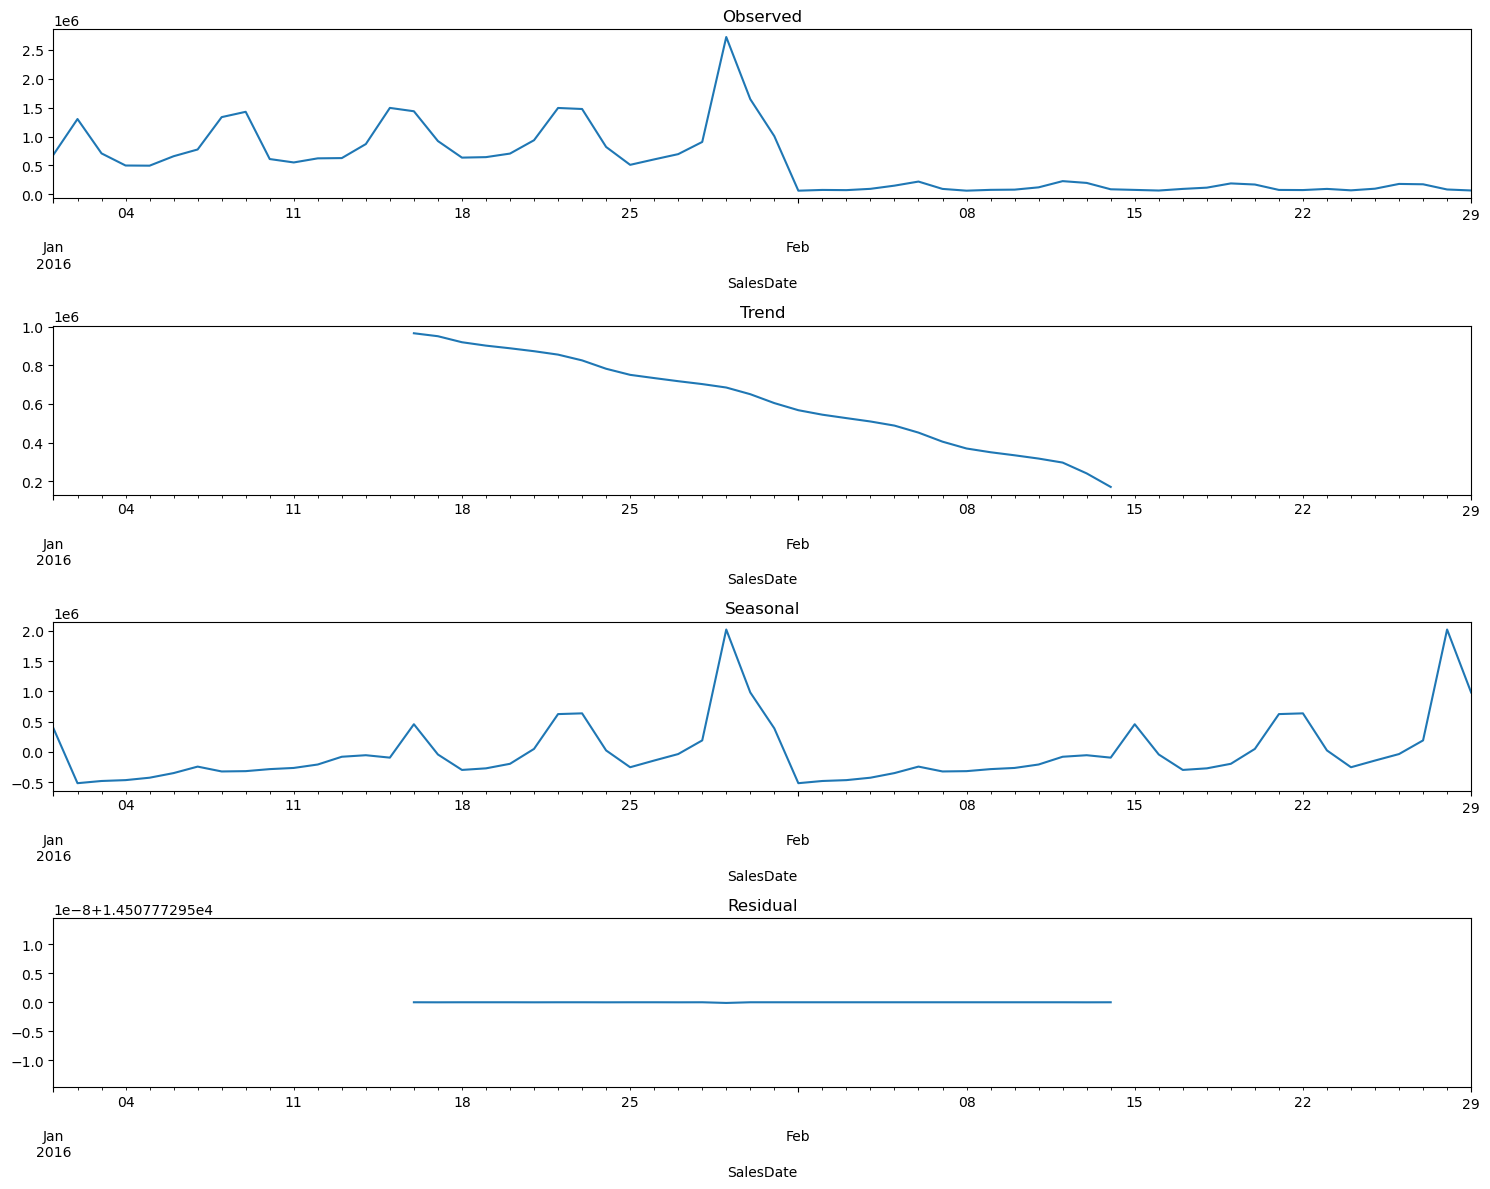

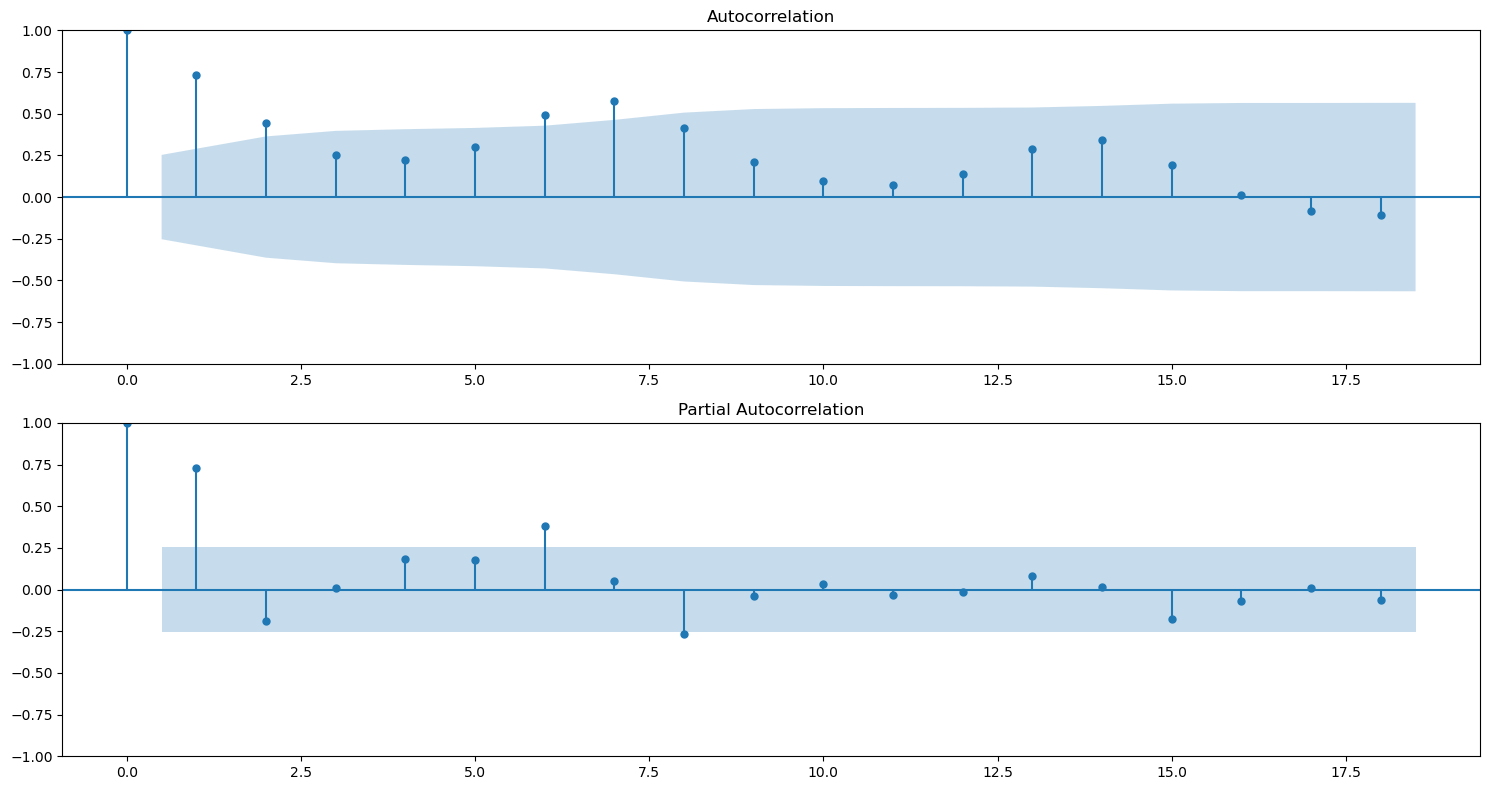

In [4]:


# Convert SalesDate to datetime
sales_data['SalesDate'] = pd.to_datetime(sales_data['SalesDate'])

# Group by date to get daily sales
daily_sales = sales_data.groupby('SalesDate')['SalesDollars'].sum().reset_index()
daily_sales = daily_sales.set_index('SalesDate')

# Plot total sales over time
plt.figure(figsize=(15, 6))
daily_sales['SalesDollars'].plot()
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.show()

# Seasonal Decomposition
decomposition = seasonal_decompose(daily_sales['SalesDollars'], period=30)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Residual')
plt.tight_layout()
plt.show()

# ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
plot_acf(daily_sales['SalesDollars'], ax=ax1)
plot_pacf(daily_sales['SalesDollars'], ax=ax2)
plt.tight_layout()
plt.show()

In [ ]:
def create_features(df):
    """
    Create time series features based on date index
    """
    df = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    

    df['sales_lag1'] = df['SalesDollars'].shift(1)
    df['sales_lag7'] = df['SalesDollars'].shift(7)
    df['sales_lag30'] = df['SalesDollars'].shift(30)
    

    df['rolling_mean_7'] = df['SalesDollars'].rolling(window=7).mean()
    df['rolling_mean_30'] = df['SalesDollars'].rolling(window=30).mean()
    

    df['rolling_std_7'] = df['SalesDollars'].rolling(window=7).std()
    df['rolling_std_30'] = df['SalesDollars'].rolling(window=30).std()

    df = pd.get_dummies(df, columns=['month', 'day_of_week'])
    
    return df

features_df = create_features(daily_sales)
features_df = features_df.dropna()  

print("Features created:")
print(features_df.columns.tolist())

Features created:
['SalesDollars', 'year', 'day', 'quarter', 'sales_lag1', 'sales_lag7', 'sales_lag30', 'rolling_mean_7', 'rolling_mean_30', 'rolling_std_7', 'rolling_std_30', 'month_1', 'month_2', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6']


In [6]:

def calculate_metrics(y_true, y_pred):
    """Calculate common time series metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

# Prepare features and target
X = features_df.drop('SalesDollars', axis=1)
y = features_df['SalesDollars']

# Create TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)

In [8]:
def train_and_evaluate_models(X, y):
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=10),
        'XGBoost': XGBRegressor(n_estimators=100, random_state=10)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        metrics_list = []
        
        for train_idx, val_idx in tscv.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            model.fit(X_train, y_train)
            y_pred = model.fit(X_train, y_train).predict(X_val)
            
            metrics = calculate_metrics(y_val, y_pred)
            metrics_list.append(metrics)
        
        # Calculate average metrics
        avg_metrics = {
            metric: np.mean([m[metric] for m in metrics_list])
            for metric in metrics_list[0].keys()
        }
        results[name] = avg_metrics
        
    return results, models

# Train and evaluate models
results, trained_models = train_and_evaluate_models(X, y)

# Print results
for model_name, metrics in results.items():
    print(f"\n{model_name} Results:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")


Training Random Forest...

Training XGBoost...

Random Forest Results:
MAE: 38070.48
RMSE: 45143.58
MAPE: 34.63

XGBoost Results:
MAE: 35817.49
RMSE: 49958.17
MAPE: 27.45


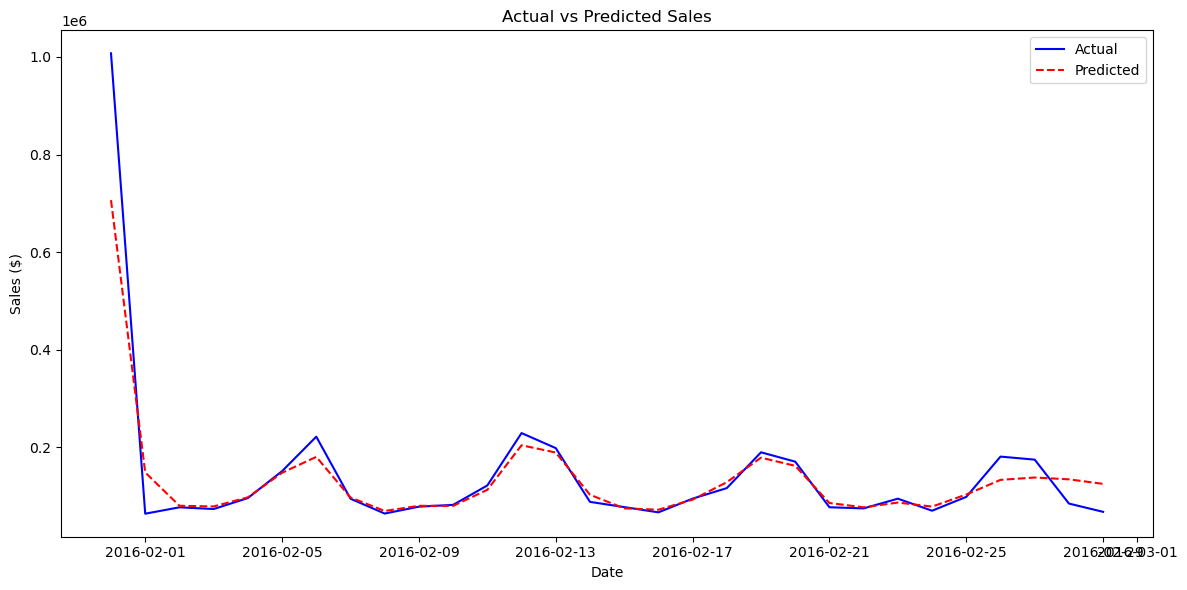

In [9]:
def plot_forecasts(model, X, y, steps=30):
    """Plot actual vs predicted values for the last 30 days"""
    # Get the last 30 days of actual data
    y_actual = y[-steps:]
    X_test = X[-steps:]
    
    # Generate predictions
    y_pred = model.predict(X_test)
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(y_actual.index, y_actual.values, label='Actual', color='blue')
    plt.plot(y_actual.index, y_pred, label='Predicted', color='red', linestyle='--')
    plt.title('Actual vs Predicted Sales')
    plt.xlabel('Date')
    plt.ylabel('Sales ($)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot forecasts for best performing model
best_model_name = min(results, key=lambda x: results[x]['RMSE'])
plot_forecasts(trained_models[best_model_name], X, y)